# How to optimize parameters using cerebro's optstrategy

Backtrader created a way to run multiple backtests in order to find best parameters. By using optstrategy, we can easily test a range of parameters and calculate the impact of the parameter changes on backtest performance.

## Import libraries

In [1]:
from datetime import datetime
import backtrader as bt
import backtrader.feeds as btfeeds
import backtrader.analyzers as btanalyzers
import pandas as pd
import matplotlib

In [2]:
# How to load data from a csv file
data = btfeeds.GenericCSVData(
    # location of the csv file used
    dataname='data/orcl-1995-2014.csv',
    # enter start and end dates
    fromdate=datetime(1996, 1, 1),
    todate=datetime(1997, 12, 31),
    # what to do if value is missing
    nullvalue=0.0,
    # Spicify date format in csv file
    dtformat=('%Y-%m-%d'),
    # clarify containt of columns
    datetime=0,  # dates as index (col0)
    open=1,  # open is col1
    high=2,  # high is col2
    low=3,  # low is col3
    close=4,  # close is col4
    # We do not use adj close, which is col5
    volume=6,  # volume is col6
    openinterest=-1  # no openinterest col
)

Create strategy class using crossovers of simple moving averages

In [3]:
class MaCrossStrategy(bt.Strategy):
 
    params = (
        ('fast_length', 10),
        ('slow_length', 50)
    )
     
    def __init__(self):
        ma_fast = bt.ind.SMA(period = self.params.fast_length)
        ma_slow = bt.ind.SMA(period = self.params.slow_length)
         
        self.crossover = bt.ind.CrossOver(ma_fast, ma_slow)
 
    def next(self):
        if not self.position:
            if self.crossover > 0: 
                self.buy()
        elif self.crossover < 0: 
            self.close()

Run Backtrader optstrategy. Notice that we will need to specify metrics on which to assess the backtests performance. Here, we will assess the Sharpe Ratio, absolute Performance and drawdown at the end of the backtest. This can be done by using analyzers.  
For further details on analyszers, have a look at this tutorial: https://www.backtrader.com/docu/analyzers/analyzers/

In [4]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Create a Data Feed from csv file
data = btfeeds.GenericCSVData(
    # location of the csv file used
    dataname='data/orcl-1995-2014.csv',
    # enter start and end dates
    fromdate=datetime(1996, 1, 1),
    todate=datetime(1997, 12, 31),
    # what to do if value is missing
    nullvalue=0.0,  # default is float('NaN')
    # Spicify date format in csv file
    dtformat=('%Y-%m-%d'),
    # clarify containt of columns
    datetime=0,  # dates as index (col0)
    open=1,  # open is col1
    high=2,  # high is col2
    low=3,  # low is col3
    close=4,  # close is col4
    # We do not use adj close, which is col5
    volume=6,  # volume is col6
    openinterest=-1  # no openinterest col
)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Run optimizer on a range of SMA value
strats = cerebro.optstrategy(
    MaCrossStrategy,
    fast_length = range(1, 11), # testing value between 1 and 10
    slow_length = range(25, 76, 5))  # Range of value 25 to 75, step 5

# Set our desired cash start
cerebro.broker.setcash(100000.0)

cerebro.addsizer(bt.sizers.PercentSizer, percents = 10)
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name = "sharpe")
cerebro.addanalyzer(btanalyzers.DrawDown, _name = "drawdown")
cerebro.addanalyzer(btanalyzers.Returns, _name = "returns")

# Run over everything
results = cerebro.run()

At the end of the backtest, results are saved in the 'results' variable. It is a list of backtesting results that we can parse.

We can use a list comprehension to extract parameters and attached metrics

In [5]:
par_list = [[x[0].params.fast_length, 
             x[0].params.slow_length,
             x[0].analyzers.returns.get_analysis()['rnorm100'], 
             x[0].analyzers.drawdown.get_analysis()['max']['drawdown'],
             x[0].analyzers.sharpe.get_analysis()['sharperatio']
            ] for x in results]

Create a DataFrame and add column names

In [6]:
par_df = pd.DataFrame(par_list, columns = ['length_fast', 'length_slow', 'return', 'dd', 'sharpe'])

Show results sorted by return

In [7]:
par_df.sort_values(by='return', ascending=False)

,length_fast,length_slow,return,dd,sharpe
76,7,75,2.528748,2.011212,3.244185
65,6,75,2.422487,1.967744,2.295689
32,3,75,2.390954,2.196764,1.963682
43,4,75,2.364304,2.292525,1.458218
28,3,55,2.325332,1.839226,0.911051
...,...,...,...,...,...
99,10,25,-0.558461,4.585934,-0.863624
100,10,30,-0.618333,4.590659,-2.038505
2,1,35,-1.015108,4.746139,-4.356043
1,1,30,-1.266258,5.333577,-4.006829


Next, we can perform a full backtest with optimized parameters

In [8]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Create a Data Feed from csv file
data = btfeeds.GenericCSVData(
    # location of the csv file used
    dataname='data/orcl-1995-2014.csv',
    # enter start and end dates
    fromdate=datetime(1996, 1, 1),
    todate=datetime(1997, 12, 31),
    # what to do if value is missing
    nullvalue=0.0,  # default is float('NaN')
    # Spicify date format in csv file
    dtformat=('%Y-%m-%d'),
    # clarify containt of columns
    datetime=0,  # dates as index (col0)
    open=1,  # open is col1
    high=2,  # high is col2
    low=3,  # low is col3
    close=4,  # close is col4
    # We do not use adj close, which is col5
    volume=6,  # volume is col6
    openinterest=-1  # no openinterest col
)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Run optimizer with optimized parameters
strats = cerebro.addstrategy(
    MaCrossStrategy,
    fast_length = 7,
    slow_length = 75)

# Set our desired cash start
cerebro.broker.setcash(100000.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
Final Portfolio Value: 100002.24


Show backtest results on a graph

<IPython.core.display.Javascript object>


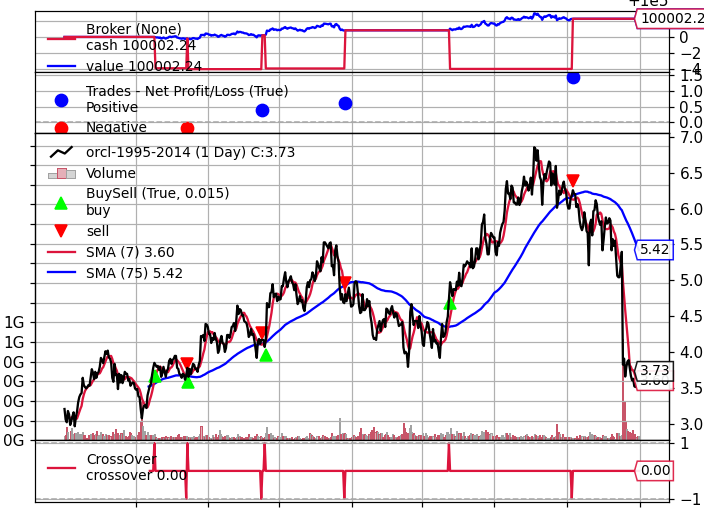

[[<Figure size 640x480 with 5 Axes>]]

In [10]:
cerebro.plot()